In [3]:
from functools import partial
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
from uncertainty_testbed.generators.data_generator_explicit import AnalyticBinaryClassGenerator
from uncertainty_testbed.utilities.functions import map_to_constant, safe_logodds
from uncertainty_testbed.uncertainty_models.mc_dropout import MCDropoutLayer, MCDropoutKerasClassification

2022-06-23 11:16:06.393573: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-23 11:16:06.393604: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.01
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [3]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0084),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6


2022-05-10 14:53:37.972452: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-10 14:53:37.972486: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-10 14:53:37.972511: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-05-10 14:53:37.972795: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4160/4160 [==============================] - 7s 2ms/step - loss: 0.2800 - accuracy: 0.8774 - auc: 0.9532 - val_loss: 0.1911 - val_accuracy: 0.9284 - val_auc: 0.9784
Epoch 2/6
4160/4160 [==============================] - 6s 1ms/step - loss: 0.1557 - accuracy: 0.9412 - auc: 0.9848 - val_loss: 0.1429 - val_accuracy: 0.9437 - val_auc: 0.9882
Epoch 3/6
4160/4160 [==============================] - 6s 1ms/step - loss: 0.1291 - accuracy: 0.9530 - auc: 0.9892 - val_loss: 0.1221 - val_accuracy: 0.9567 - val_auc: 0.9908
Epoch 4/6
4160/4160 [==============================] - 6s 1ms/step - loss: 0.1182 - accuracy: 0.9568 - auc: 0.9907 - val_loss: 0.1059 - val_accuracy: 0.9637 - val_auc: 0.9920
Epoch 5/6
4160/4160 [==============================] - 6s 1ms/step - loss: 0.1066 - accuracy: 0.9641 - auc: 0.9916 - val_loss: 0.0977 - val_accuracy: 0.9682 - val_auc: 0.9927
Epoch 6/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.1016 - accuracy: 0.9659 - auc: 0.9926 - val_loss: 0.1107 -

In [4]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

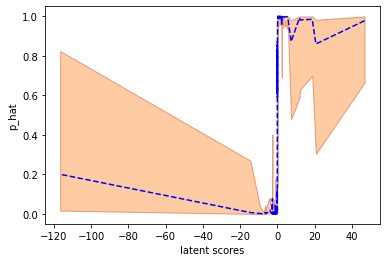

In [5]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

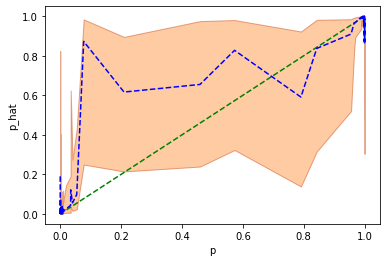

In [6]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [7]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-05-10 14:54:17.189202: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.273075: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.282335: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:54:17.347965: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-05-10 14:55:26.044641: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.01: 76.21% within 90% CI


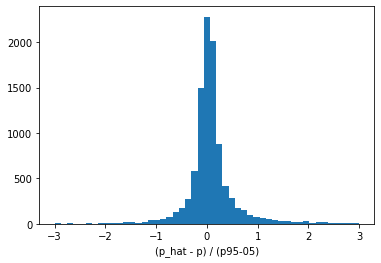

In [8]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.01: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

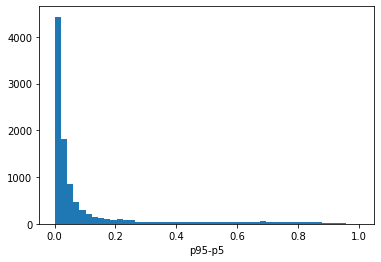

In [9]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [10]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.1
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [11]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6
4160/4160 [==============================] - 7s 2ms/step - loss: 0.4025 - accuracy: 0.8235 - auc: 0.9043 - val_loss: 0.3199 - val_accuracy: 0.8832 - val_auc: 0.9388
Epoch 2/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2868 - accuracy: 0.8956 - auc: 0.9488 - val_loss: 0.2756 - val_accuracy: 0.8982 - val_auc: 0.9521
Epoch 3/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2629 - accuracy: 0.9052 - auc: 0.9555 - val_loss: 0.2601 - val_accuracy: 0.9054 - val_auc: 0.9565
Epoch 4/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2509 - accuracy: 0.9112 - auc: 0.9585 - val_loss: 0.2514 - val_accuracy: 0.9100 - val_auc: 0.9587
Epoch 5/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2468 - accuracy: 0.9135 - auc: 0.9595 - val_loss: 0.2519 - val_accuracy: 0.9115 - val_auc: 0.9591
Epoch 6/6
4160/4160 [==============================] - 6s 2ms/step - loss: 0.2422 - accuracy: 0.9157 - auc: 0.9610 - val_loss

In [12]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

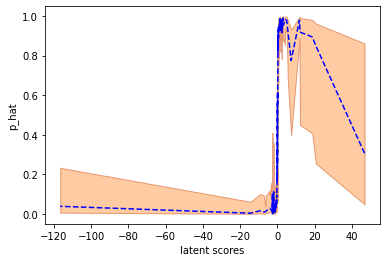

In [13]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

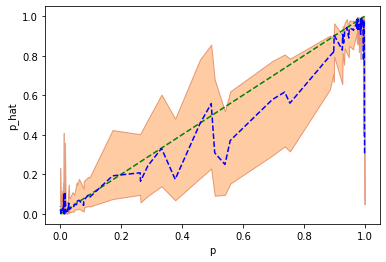

In [14]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [15]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

For noise level: 0.1: 83.2% within 90% CI


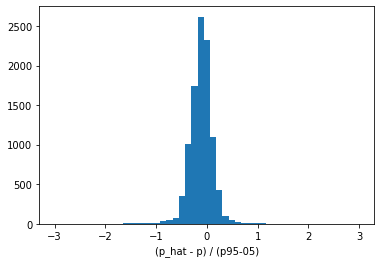

In [16]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.1: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

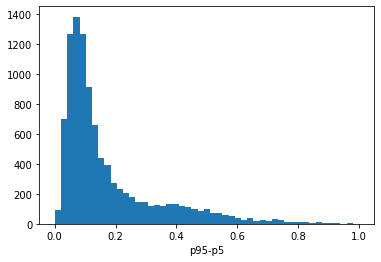

In [17]:
plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()

In [4]:
#def generate_chisq_chisq_data(num_train=100000, num_val=20000, noise_level=0.):
num_train_g=100096
num_train = 33280
num_val=20000
noise_level=0.3
# generate some data
s = partial(map_to_constant, c=noise_level)
eg = AnalyticBinaryClassGenerator(seed=42, num_inputs=10, name="cauchy", threshold=0.5,
                                  noise_distribution="cauchy", noise_scale=s)
x, y = eg.generate_labeled(num_train_g + num_val)
x = x.astype("float32")
y = y.astype("uint8")
x_train, y_train = x[:num_train, :], y[:num_train]
x_val, y_val = x[num_train_g:, :], y[num_train_g:]
#return x_train, y_train, x_val, y_val

In [5]:
layers = (
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(60, activation="relu"),
    MCDropoutLayer(0.25),
    keras.layers.Dense(1, activation="sigmoid")
)
mcd_classifier = MCDropoutKerasClassification(
    layer_tuple=layers,
    optimizer=keras.optimizers.Adamax(learning_rate=0.0056),
    loss="binary_crossentropy",
    metrics=("accuracy", "AUC"),
    name="MCDropout"
)
mcd_classifier.fit(
    x_train,
    y_train,
    epochs=6,
    batch_size=8,
    validation_data=(x_val, y_val)
)

Epoch 1/6


2022-06-23 11:16:32.774129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-23 11:16:32.774233: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-23 11:16:32.774304: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (xps): /proc/driver/nvidia/version does not exist
2022-06-23 11:16:32.776086: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


4160/4160 [==============================] - 10s 2ms/step - loss: 0.5114 - accuracy: 0.7635 - auc: 0.8376 - val_loss: 0.4332 - val_accuracy: 0.8209 - val_auc: 0.8869
Epoch 2/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.4153 - accuracy: 0.8264 - auc: 0.8941 - val_loss: 0.4000 - val_accuracy: 0.8377 - val_auc: 0.9033
Epoch 3/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3932 - accuracy: 0.8368 - auc: 0.9041 - val_loss: 0.3849 - val_accuracy: 0.8418 - val_auc: 0.9083
Epoch 4/6
4160/4160 [==============================] - 8s 2ms/step - loss: 0.3877 - accuracy: 0.8400 - auc: 0.9065 - val_loss: 0.3799 - val_accuracy: 0.8497 - val_auc: 0.9125
Epoch 5/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3793 - accuracy: 0.8434 - auc: 0.9108 - val_loss: 0.3807 - val_accuracy: 0.8451 - val_auc: 0.9129
Epoch 6/6
4160/4160 [==============================] - 9s 2ms/step - loss: 0.3780 - accuracy: 0.8462 - auc: 0.9111 - val_loss: 0.3739 

In [6]:
# compute, sort, and smooth all quantities to plot
n = 1  # smoothing window for convolutions in plots
s = 300  # number of samples to use in mean and percentile estimates
post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:100, :], n=s)

p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:100, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

scores = eg.get_scores(x_val[:100,:])
ix_srt = np.argsort(scores)

probs = eg.get_probabilities(x_val[:100,:])[1]

p = np.convolve(p[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_l = np.convolve(p_l[ix_srt[::-1]], np.ones(n)/n, mode='valid')
p_h = np.convolve(p_h[ix_srt[::-1]], np.ones(n)/n, mode='valid')
scores = np.convolve(scores[ix_srt[::-1]], np.ones(n)/n, mode='valid')
probs = np.convolve(probs[ix_srt[::-1]], np.ones(n)/n, mode='valid')

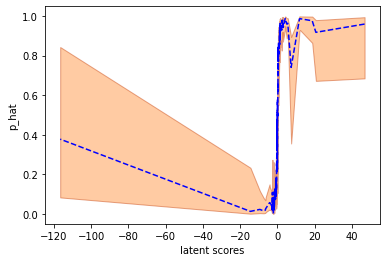

In [7]:
plt.plot(scores, p, '--b')
plt.fill_between(scores, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('latent scores')
plt.ylabel('p_hat')
plt.show()

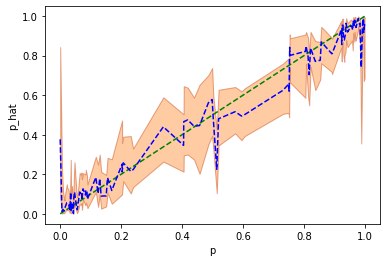

In [8]:
plt.plot(probs, probs, '--g')
plt.plot(probs, p, '--b')
plt.fill_between(probs, p_l, p_h, 
                 alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848')
plt.xlabel('p')
plt.ylabel('p_hat')
plt.show()

In [9]:
# find percentage of 95% confidence intervals containing the true probability
s = 300  # number of posterior samples to sample for posterior for each x
d = 10000  # number of x samples points to use

post_lo_mean = mcd_classifier.posterior_mean_logodds(x_val[:d, :], n=s)
p = 1/(1 + np.exp(-post_lo_mean[:, 0]))
ptiles = mcd_classifier.posterior_percentile_proba(x_val[:d, :], n=s, q=(5, 95), axis=0)
p_l = ptiles[0, :, 0]
p_h = ptiles[1, :, 0]

probs = eg.get_probabilities(x_val[:d,:])[1]
logodds = safe_logodds(probs)

2022-06-23 11:17:27.666319: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.
2022-06-23 11:17:27.807794: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-06-23 11:17:27.816800: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-06-23 11:17:27.889203: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 24000000 exceeds 10% of free system memory.
2022-06-23 11:19:00.042411: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120000000 exceeds 10% of free system memory.


For noise level: 0.3: 90.19% within 90% CI


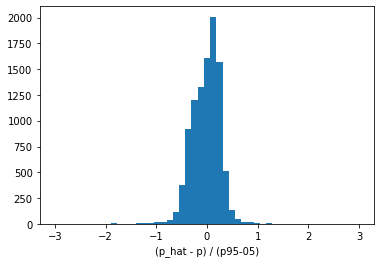

In [10]:
inside = np.logical_and(np.less_equal(p_l, probs), np.less_equal(probs, p_h))
print ("For noise level: 0.3: {}% within 90% CI".format(100*np.mean(inside)))

normed_p_dist = (p - probs) /(1e-16 + p_h - p_l)
plt.hist(normed_p_dist, bins=np.linspace(-3,3))
plt.xlabel('(p_hat - p) / (p95-05)')
plt.show()

Percentage of 90% CI below 0.2: 0.6071
Average p95: 0.5985038148652018


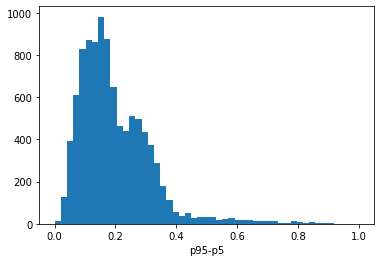

In [11]:
thr = 0.2
print("Percentage of 90% CI below {}: {}". format(thr, np.mean(np.less_equal(p_h - p_l, thr))))
print("Average p95: {}".format(np.mean(p_h)))

plt.hist(p_h - p_l, bins=np.linspace(0.,1.))
plt.xlabel('p95-p5')
plt.show()